In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 지수분포를 이용하여 오른쪽으로 치우친 데이터 생성
np.random.seed(0)
data = np.random.exponential(scale=1000, size=1000)
df = pd.DataFrame(data, columns=['value'])

# 시각화를 위한 함수 정의
def plot_distribution(df, column, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], kde=True)
    plt.title(f'Histogram of {title}')
    plt.subplot(1, 2, 2)
    stats.probplot(df[column], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {title}')
    plt.show()

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import gaussian_kde

# 지수분포를 이용하여 오른쪽으로 치우친 데이터 생성
np.random.seed(0)
data = np.random.exponential(scale=1000, size=1000)
df = pd.DataFrame(data, columns=['value'])

def plot_distribution(df, column, title):
    plt.figure(figsize=(12, 4))
    
    # (1) Histogram + KDE
    plt.subplot(1, 2, 1)
    data = df[column].dropna()
    
    # 히스토그램 (density=True → 확률밀도로 표시)
    plt.hist(data, density=True, alpha=0.6, color='skyblue', edgecolor='black')
    
    # KDE 추가
    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 200)
    plt.plot(x, kde(x), color='red', linewidth=2)
    
    plt.title(f'Histogram of {title}')
    
    # (2) Q-Q Plot
    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {title}')
    
    plt.tight_layout()
    plt.show()


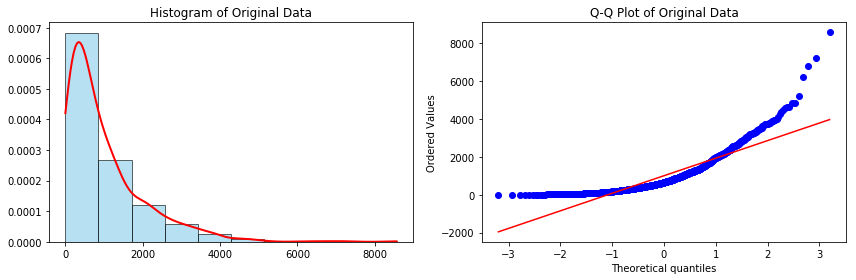

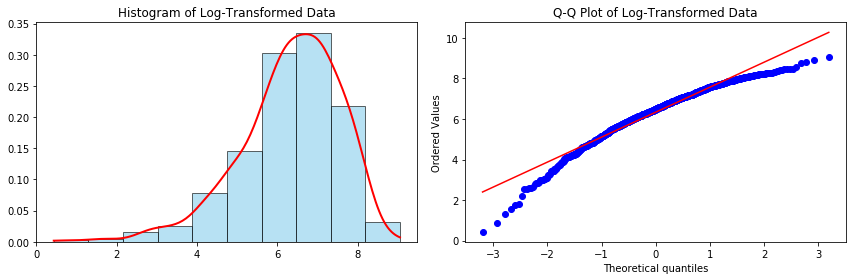

In [17]:
from scipy import stats

# 원본 데이터 분포 확인
plot_distribution(df, 'value', 'Original Data')

# 로그 변환 (log1p는 log(1+x)를 계산하여 0을 처리)
df['log_value'] = np.log1p(df['value'])

# 변환 후 데이터 분포 확인
plot_distribution(df, 'log_value', 'Log-Transformed Data')

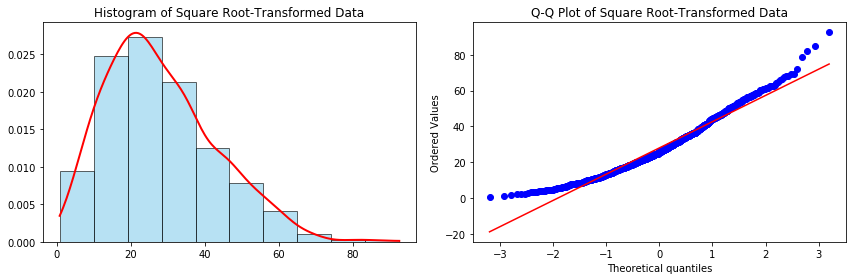

In [18]:
# 제곱근 변환
df['sqrt_value'] = np.sqrt(df['value'])

# 변환 후 데이터 분포 확인
plot_distribution(df, 'sqrt_value', 'Square Root-Transformed Data')

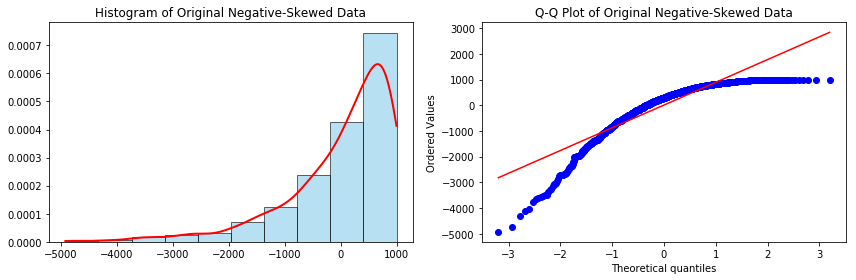

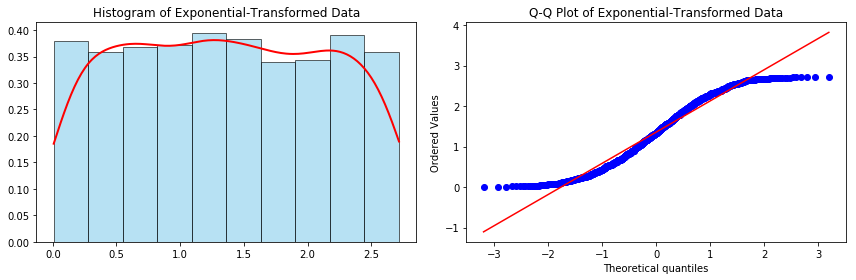

In [23]:
# 좌측으로 치우친 데이터 생성
np.random.seed(1)
neg_data = -np.random.exponential(scale=1000, size=1000)+1000
df_neg = pd.DataFrame(neg_data, columns=['value'])

# 원본 데이터 분포 확인
plot_distribution(df_neg, 'value', 'Original Negative-Skewed Data')

# 지수 변환
df_neg['exp_value'] = np.exp(df_neg['value'] / 1000)  # 스케일 조정 후 exp 적용

# 변환 후 데이터 분포 확인
plot_distribution(df_neg, 'exp_value', 'Exponential-Transformed Data')

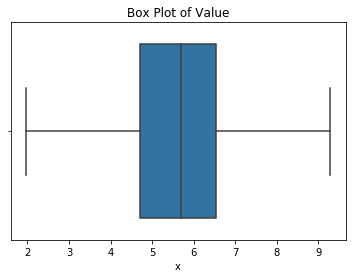

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.boxplot(x=df_capped['x'])
plt.title('Box Plot of Value')
plt.show()